<a href="https://colab.research.google.com/github/niels-overby/SRP2021/blob/main/SRP_noisereduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [302]:
#@title Setup

!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

import sys
sys.path.append('/content/SRP2021/')

from audiotools import utils, processing, spectrum

# helper functions 
def interferringTone(x,fs,freq=2000,level_dB = 65):
    A = utils.from_dB(level_dB)
    xlen = np.max(x.shape)
    
    x_sin = A * np.sin(2*np.pi*freq * np.arange(xlen)/fs)
    
    return x_sin

def interferringNoise(x,fs,SNR = 10):
    x_noise = np.random.randn(*x.shape)
    x_noise, _ = utils.adjustSNR(x,x_noise,SNR)
    
    return x_noise

fatal: destination path 'SRP2021' already exists and is not an empty directory.


# Del 3: Støjreduktion

I forrige øvelse så vi at støjfyldte signaler kan behandles i tids-frekvens domænet, og på den måde forbedre et ønsket signal. I bedste tilfælde kunne støjen fjernes fuldstændigt uden at det ønskede signal blev forringet. I virkelige scenarier er det dog sjældent at almindelige filtre kan benyttes til at fjerne støj. Dette vil vi undersøge i denne del af øvelsen.




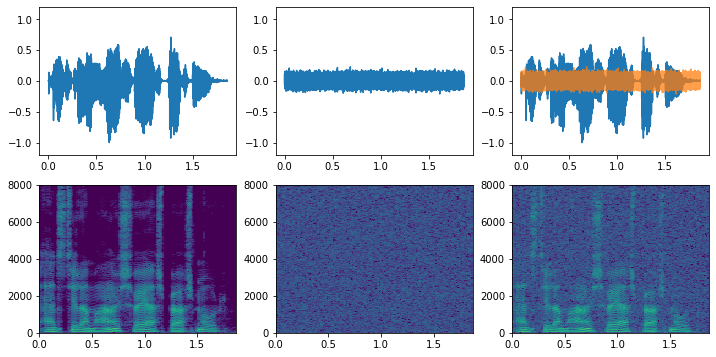

In [ ]:
#@title Eksempel på støj i talesignal
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))


x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = processing.normalize().transform(x)

x_noise = interferringNoise(x,fs,SNR=10)
x_m = x+x_noise

maxval = np.max(np.abs(x))

stft = spectrum.STFT(fs=fs,nperseg=2048,nfft=2)
Xm = stft.transform(x_m)
X = stft.transform(x)
Xn = stft.transform(x_noise)

display(utils.play(x,fs))
display(utils.play(x_noise,fs))
display(utils.play(x_m,fs))


plt.figure(figsize=(12,6))

#plot tale
plt.subplot(231)
t = np.arange(len(x.T))/fs
plt.plot(t,x.T/maxval)
plt.ylim([-1.2,1.2])

plt.subplot(234)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=0,vmax=90)
plt.ylim([0,8000])

#plot noise
plt.subplot(232)
plt.plot(t,x_noise.T/maxval)
plt.ylim([-1.2,1.2])

plt.subplot(235)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xn[0])),vmin=0,vmax=90)
plt.ylim([0,8000])

#plot mix
plt.subplot(233)
plt.plot(t,x.T/maxval)
plt.plot(t,x_noise.T/maxval,alpha=0.75)
plt.ylim([-1.2,1.2])

plt.subplot(236)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xm[0])),vmin=0,vmax=90)
plt.ylim([0,8000])



plt.show()

* Beskriv hvordan signalet oven for lyder, og hvad forskellen er fra denne type støj og de eksempler vi arbejdede med i forrige øvelse.
* Hvordan kan støjen ses i spektrogrammet?

* Hvorfor kan lavpas- højpas- eller båndstop-filtre ikke bruges til at fjerne netop denne type støj?



# Måling af signal-støj forhold

Før vi starter med støjreduktion skal vi først forstå hvordan vi arbejder med støjfyldte signaler. Hvis et talesignal er mixet sammen med et støjsignal taler man ofte om signal-støjforhold som er en værdi der udtrykker hvor meget signalstyrken i forhold til støjstyrken.

I dette afsnit vil vi se på målemetoder til at bestemme signal styrken på digitale signaler, samt beregne signal støjforhold.


## Root mean square
Første del af at beregne signal-støjforholdet er ved at beregne signalstyrken af de signaler som et mix består af.

Signalstyrken kan måles i root-mean-square (forkortet: RMS). RMS beregnes ved at tage kvadratroden af middelværdien af signalet i anden potens. Matematisk kan det udtrykkes som i formlen nedenfor:

$x_{RMS} = \sqrt{\dfrac{1}{N}\sum_{n=0}^{N} x^2[n]}$,

Hvor $N$ er antallet af samples i signalet $x$. 

**Eksempel:**

Vi ønsker at beregne RMS værdien for et signal bestående af 8 elementer $x[n] = [0,1,0,-1,0,1,0,-1]$.
1. Signalet opløftes i anden potens: $x^2[n] =  [0,1,0,1,0,1,0,1]$
2. Middelværdien beregnes $\dfrac{1}{N} \sum_{n=0}^{N} x^2[n] = \dfrac{1}{8}(0+1+0+1+0+1+0+1)  = 0.5 $
3. Kvadratroden berenges, $x_{RMS} = \sqrt{0.5} \simeq 0.707$

RMS kan fortolkes som den gennemsnitlige amplitude af et vilkårligt signal.


## Beregning af signal-støj forhold

Signal-støj forholdet kan beregnes som forholdet mellem RMS værdien for signalet og støjen i anden potens.

$SNR = \big(\dfrac{A_s}{A_n}\big)^2$,

hvor $A_s$ er RMS amplituden for signalet, og $A_n$ er RMS amplituden for støjen. Da SNR udtrykkes i effekt og ikke i amplitude, opløftes forholdet i anden potens.

Typisk benyttes SNR$_{dB}$ som er decibel værdien af signal-støj forholdet. Decibel er en logaritmisk enhed til at beskrive forhold mellem signalniveauer. Fordelen ved at bruge en logaritmisk enhed er at den er tættere beslægtet på hvordan vi mennesker opfatter ændringer i lydniveauer.

$SNR_{dB} = 10 \log_{10} \big(\dfrac{A_s}{A_n}\big)^2 = 20 \log10\big(\dfrac{A_s}{A_n}\big)$

* Beregn signal-støj forholdet i dB hvis signalet og støjen har samme RMS amplitude
* Bereng signal-støj forholdet hvis signalet har den dobbelte RMS amplitude af støjen.
* Beregn igen signal-støj forholdet hvis støjen har den 3 dobbelte RMS amplitude af signalet.




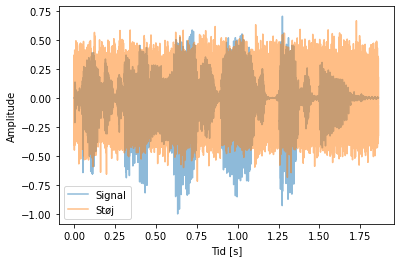

In [316]:
#@title SNR widget {run : "auto"}
#@markdown Prøv at ændre signal-støj forholdet ved brug af slideren.
#@markdown * Ved hvilken SNRdB værdi begynder det at blive svært at forstå taleren?

audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))

x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = x/np.max(np.abs(x))
SNRdB = 0 #@param {type:"slider",min:-24,max:24}
xnoise = interferringNoise(x,fs,SNR=SNRdB)

t = np.arange(len(x.T))/fs

plt.plot(t,x.T,alpha=0.5,label='Signal')
plt.plot(t,xnoise.T,alpha=0.5,label='Støj')
plt.xlabel("Tid [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

display(utils.play(x+xnoise,fs))

# Støjreduktion
Hvis man undersøger spektrogrammet ses det at lydniveauet af talesignalet er højere end lydniveauet af baggrundsstøjen. Denne information kan benyttes til at designe et filter der fjerner lave lyde og bevarer høje lyde. 



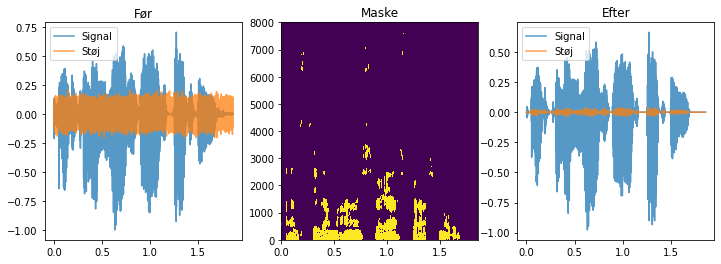

In [433]:
#@title processing {run : "auto"}

audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))

x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = x/np.max(np.abs(x))
SNRdB = 10 #@param {type:"slider",min:-24,max:24}
xn = interferringNoise(x,fs,SNR=SNRdB)
xm = x + xn
t = np.arange(len(x.T))/fs

stft = spectrum.STFT(nperseg=512,fs=fs)

# Compute STFTs
X = stft.transform(x)
Xn = stft.transform(xn)
Xm = stft.transform(xm)

# Thresholding in log spectrogram, that way the linear slider makes more sense
XmLog = np.log(np.abs(Xm))
minVal = np.min(XmLog)
maxVal = np.max(XmLog)

threshold_percent = 79 #@param {type:"slider", min:0, max:100, step:1}
a = threshold_percent/100

thr = a * maxVal + (1-a) * minVal
mask = XmLog > thr

Y = mask * X
Yn = mask * Xn
Ym = mask * Xm

y = stft.transform(Y,inv=True)
yn = stft.transform(Yn,inv=True)
ym = stft.transform(Ym)

#plt.pcolormesh(stft.t,stft.f,mask[0])

plt.figure(figsize=(12,4))

plt.subplot(131)
t = np.arange(len(x.T))/fs
plt.plot(t,x.T,label='Signal',alpha=0.75)
plt.plot(t,xn.T,label='Støj',alpha=0.75)
plt.title("Før")
plt.legend()

plt.subplot(132)
plt.pcolormesh(stft.t,stft.f,mask[0])
plt.ylim([0,8000])
plt.title("Maske")


plt.subplot(133)
t = np.arange(len(y.T))/fs
plt.plot(t,y.T,label='Signal',alpha=0.75)
plt.plot(t,yn.T,label='Støj',alpha=0.75)
plt.title("Efter")
plt.legend()

#plt.plot(t,x.T,alpha=0.5,label='Signal')
#plt.plot(t,xnoise.T,alpha=0.5,label='Støj')
#plt.xlabel("Tid [s]")
#plt.ylabel("Amplitude")
#plt.legend()
#plt.show()

#display(utils.play(x+xnoise,fs))


#threshold = 33 #@param {type:"slider"}

#XmLevel = 20*np.log10(np.abs(Xm))

#mask = XmLevel > threshold


#Ym = (mask * np.abs(Xm)) * np.exp(1j*np.angle(Xm))
#plt.pcolormesh(stft.t,stft.f,mask[0])

#plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Ym[0])))
#plt.ylim([0,4000])

#y = stft.transform(Ym,inv=True)

display(utils.play(ym,fs))
display(utils.play(yn,fs))


* todo: make a tool that gives the signal and noise energy levels, and let them calculate the SNR. 

* there should be at least 2 examples on noise reduction. One in high SNR and one in low SNR

* They should understand the limitations 